## 异常检测——线性模型
主要内容包括：  
1、数据可视化代码实现  
2、用PCA模型分析乳腺癌数据 




## 1、数据可视化代码实现 
以breast-cancer-unsupervised-ad数据集为例做一些简单的数据可视化

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
warnings.filterwarnings('ignore')
path = 'dataverse_files/'
f=open(path+'breast-cancer-unsupervised-ad.csv')
Train_data = pd.read_csv(f)
print(Train_data.head())

Train_data.tail()
print(Train_data.describe())
print(Train_data.info())

numeric_features = ['f' + str(i) for i in range(30)]

## 1) 相关性分析
numeric = Train_data[numeric_features]
correlation = numeric.corr()

f , ax = plt.subplots(figsize = (14, 14))

sns.heatmap(correlation,square = True)
plt.title('Correlation of Numeric Features with Price',y=1,size=16)
plt.show()



数据有30列，每列是一个乳腺癌的特征，对30个特征进行分析，查找特征间的相关性。  
numeric.corr(method='pearson',min_periods=1)方法用于查找DataFrame中所有列的成对关联。method包括{pearson,kendall,spearman}  
pearson：用于衡量两个数据集合是否在一条线上面，即针对线性数据的相关系数计算，针对非线性数据会有误差。
kendall：用于反映分类变量相关性的指标，即针对无序序列的相关系数，非正太分布数据
Spearman：非线性的，非正态分析的数据的相关系数。
min_periods：样本最少的数据量  
函数返回相关系数的DataFrame如下：
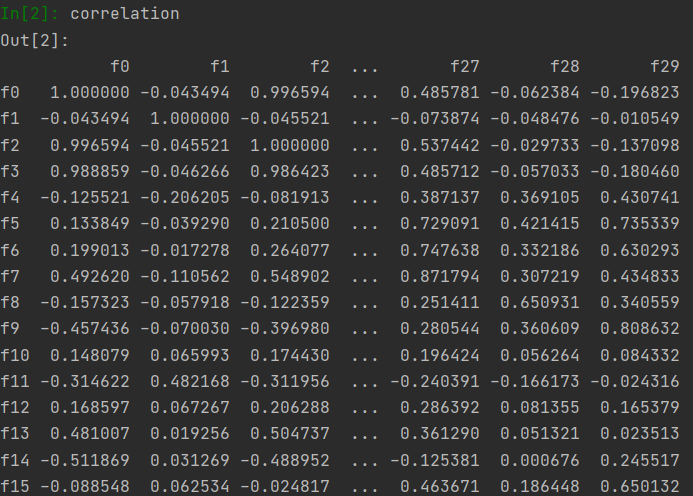  
热力图：  
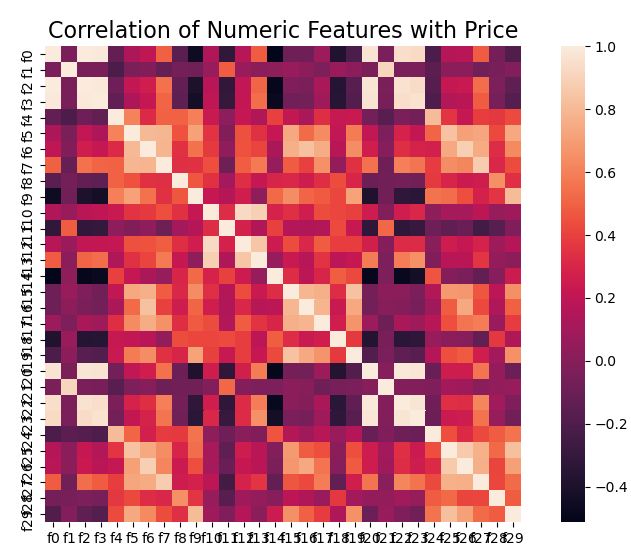

In [ ]:
## 3) 每个数字特征得分布可视化
f = pd.melt(Train_data, value_vars=numeric_features)
g = sns.FacetGrid(f, col="variable",  col_wrap=6, sharex=False, sharey=False)
g = g.map(sns.distplot, "value", hist=False, rug=True)

#变量两两之间的相关性
sns.set()
sns.pairplot(Train_data[numeric_features],size = 2 ,kind ='scatter',diag_kind='kde')
plt.savefig('correlation.png')
plt.show()


melt函数把DataFrame中的宽数据转换成长数据，即将30个特征列转换成一维数据  
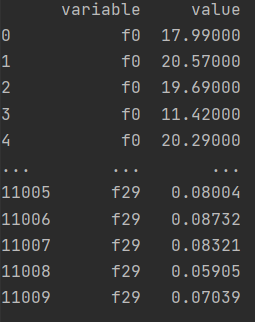  
FacetGrid函数根据每个特征绘制一幅核密度估计和地图。Pairplot则绘制每两个特征间的相关关系图（kind ='scatter'指定非对角线上是散点图,diag_kind='kde'指定对角线上是kde图）。

In [2]:

#数据降维可视化
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, init='pca', random_state=0)
result = tsne.fit_transform(numeric)
x_min, x_max = np.min(result, 0), np.max(result, 0)
result = (result - x_min) / (x_max - x_min)
label = Train_data['label']
fig = plt.figure(figsize = (7, 7))
#f , ax = plt.subplots()
color = {'o':0, 'n':7}
for i in range(result.shape[0]):
    plt.text(result[i, 0], result[i, 1], str(label[i]),
                color=plt.cm.Set1(color[label[i]] / 10.),
                fontdict={'weight': 'bold', 'size': 9})
plt.xticks([])
plt.yticks([])
plt.title('Visualization of data dimension reduction')

NameError: name 'numeric' is not defined

t-SNE是目前来说效果最好的数据降维与可视化方法，但是它的缺点也很明显，比如：占内存大，运行时间长。但是，当我们想要对高维数据进行分类，又不清楚这个数据集有没有很好的可分性（即同类之间间隔小，异类之间间隔大），可以通过t-SNE投影到2维或者3维的空间中观察一下。如果在低维空间中具有可分性，则数据是可分的；如果在高维空间中不具有可分性，可能是数据不可分，也可能仅仅是因为不能投影到低维空间。  
参数：  
n_components：int，可选（默认值：2）嵌入式空间的维度。  
init：字符串，可选（默认值：“random”）嵌入的初始化。可能的选项是“随机”和“pca”。 PCA初始化不能用于预先计算的距离，并且通常比随机初始化更全局稳定。  
TSNE转换后的数据是一组点集（即将每行的30个特征降维成2维空间的一个点），然后对点集合进行归一化（result = (result - x_min) / (x_max - x_min)）。其中
x_min：array([-392.7749  ,  -57.867374]
x_max: array([1212.2845  ,   57.472244]

数据降维后，展现在2维图中：  
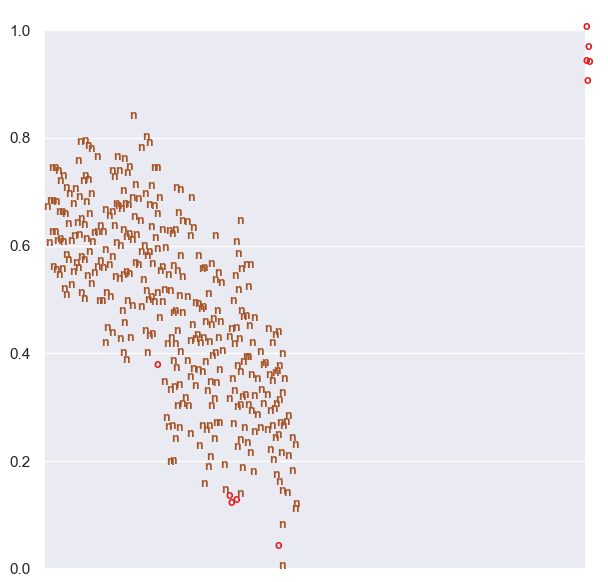

## 2、用PCA模型分析乳腺癌数据  
改写pyod库中的PCA模型例子，读取乳腺癌测试数据并运行程序，得到测试结果：  
PCA ROC:0.9789, precision @ rank n:0.6（未调参）  
代码如下：

In [ ]:
from __future__ import division
from __future__ import print_function

import os
import sys

# temporary solution for relative imports in case pyod is not installed
# if pyod is installed, no need to use the following line
sys.path.append(
    os.path.abspath(os.path.join(os.path.dirname("__file__"), '..')))

from pyod.models.pca import PCA
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
if __name__ == "__main__":
    path = 'F:\\study\\Datawhale\\o_detecter\\dataverse_files\\'
    f = open(path + 'breast-cancer-unsupervised-ad.csv')
    Train_data = pd.read_csv(f)

    contamination = 0.1  # percentage of outliers
    n_train = 200  # number of training points
    n_test = 100  # number of testing points

    # Generate sample data
    numeric_features = ['f' + str(i) for i in range(30)]
    featurePd = Train_data[numeric_features]
    labelList = Train_data['label']

    labelList = [0 if i == 'n' else 1 for i in labelList]
    x_train = featurePd[:266]
    x_test = featurePd[267:366]
    y_train = labelList[:266]
    y_test = labelList[267:366]

    # train PCA detector
    clf_name = 'PCA'
    clf = PCA(n_components=3)
    clf.fit(x_train)

    # get the prediction labels and outlier scores of the training data
    y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
    y_train_scores = clf.decision_scores_  # raw outlier scores

    # get the prediction on the test data
    y_test_pred = clf.predict(x_test)  # outlier labels (0 or 1)
    y_test_scores = clf.decision_function(x_test)  # outlier scores

    # evaluate and print the results
    print("\nOn Training Data:")
    evaluate_print(clf_name, y_train, y_train_scores)
    print("\nOn Test Data:")
    evaluate_print(clf_name, y_test, y_test_scores)